---
title: "Make predictions as lasso model of SPI tree depth & compare to model trained on OGG presence"

author: "Benjamin Doran"

date: today

---

## Setup

In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using SPI, MLJ
using MLJBase: train_test_pairs
using Clustering, Distances
using Muon, CSV, DataFrames
using StatsPlots, StatsBase
theme(:default, grid=false, label="")
using NewickTree, NewickTreeTools
using Gotree_jll
using Random: seed!
using FreqTables
using Distances
using NearestNeighbors
using HypothesisTests
using MultipleTesting: adjust, Bonferroni, BenjaminiHochberg

getlims(x) = x |> extrema |> x->abs.(x) |> maximum |> x->(-x,x)

function getlims(x, y) 
    lims = extrema(vcat(x, y))
    lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
end

Base.@kwdef struct GroupedEuclidean{T} <: Metric
    groups::Vector{T}
end
function (dist::GroupedEuclidean)(r, a, b)
    for grp in dist.groups
        r += sqrt(sum(abs2.(a[grp] .- b[grp])))
    end
    r
end
function (dist::GroupedEuclidean)(a, b)
    r = zero(eltype(a))
    dist(r, a, b)
end
function (dist::GroupedEuclidean)(a::Number, b::Number)
    euclidean(a, b)
end
groupedeuclidean(a, b, intervals=collect(axes(a,1))) = GroupedEuclidean(intervals)(a, b)
groupedeuclidean!(r, a, b, intervals=collect(axes(a,1))) = GroupedEuclidean(intervals)(r, a, b)

get_predictions(ŷ, y) = ŷ
MLJ.reports_each_observation(::typeof(get_predictions)) = true;

In [2]:
include(srcdir("helpers.jl"))

compose (generic function with 1 method)

In [3]:
# @load LogisticClassifier pkg=MLJLinearModels verbosity=0
@load LassoRegressor pkg=MLJLinearModels verbosity=0
@load MultinomialClassifier pkg=MLJLinearModels verbosity=0
@load OneHotEncoder pkg=MLJModels verbosity=0
# DecisionTreeRegressor = @load DecisionTreeRegressor pkg=DecisionTree

OneHotEncoder

In [4]:
ddir = datadir("exp_pro", "BB669")
rdir = projectdir("_research", "metabolite_SLE_Lasso_model_outofbag") |> mkpath
pdir = plotsdir("metabolite_SLE_Lasso_model_outofbag") |> mkpath
biobank = readh5mu(joinpath(ddir, "BB669.h5mu"))

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon /Users/bend/.julia/packages/Muon/eLqpV/src/mudata.jl:351


MuData object 669 ✕ 21485
└ metabolites_foldchange
  AnnData object 669 ✕ 50
└ metabolites_millimolar
  AnnData object 669 ✕ 10
└ UPorder_oggs
  AnnData object 669 ✕ 10177
└ oggs
  AnnData object 669 ✕ 11248

In [5]:
keptspecies = string.(keys(sort(filter(x-> last(x) > 19, countmap(biobank.obs.species)), byvalue=true, rev=true)))
filter!(!=("unclassified"), keptspecies)
full_train_mask = in.(biobank.obs.species, Ref(keptspecies));
full_test_mask = .!(full_train_mask);

In [6]:
countmap(filter(:species => x->contains(x, "rectale"), biobank.obs).donor)

Dict{String, Int64} with 5 entries:
  "MSK.22" => 5
  "MSK.17" => 8
  "MSK.9"  => 2
  "MSK.13" => 3
  "MSK.16" => 2

In [7]:
mtx = biobank["UPorder_oggs"].X[:,:];

In [8]:
bbusv = SVD(
    biobank["UPorder_oggs"].obsm["inferredLSVs"][:,:],
    biobank["UPorder_oggs"].uns["UP_SVs"][:],
    biobank["UPorder_oggs"].varm["UP_RSVs"][:, :]',
    );
norm(mtx .- projectout(bbusv)) / norm(mtx)

0.030226667349341582

In [9]:
metabolite_names_full = replace.(biobank["metabolites_foldchange"].var_names, "_rel"=>"");

In [10]:
bb_met_lfc = biobank["metabolites_foldchange"].X[:, :];
bb_met_lfc[isinf.(bb_met_lfc)] .= 0.0;
metabolicdistance = pairwise(Euclidean(), bb_met_lfc; dims=1);

In [11]:
bbmtx = float.(biobank["oggs"].X[:, :])
bbmtx_trn = bbmtx[full_train_mask, :]
bbmtx_tst = bbmtx[full_test_mask, :]
# filter out oggs that are constant
ogg_mask = vec(mapslices(c->std(c) > 0, bbmtx_trn, dims=1))
bbmtx_trn = bbmtx_trn[:, ogg_mask]
bbmtx_tst = bbmtx_tst[:, ogg_mask]
bbusv_internal = svd(bbmtx_trn)
BBUinternal_tst = projectinLSV(bbmtx_tst, bbusv_internal)
BBpcs_trn = bbusv_internal.U * diagm(bbusv_internal.S)
BBpcs_tst = BBUinternal_tst * diagm(bbusv_internal.S);

In [12]:
size(bbmtx)

(669, 11248)

In [13]:
size(bbmtx_trn)

(356, 5449)

In [14]:
size(bbmtx_tst)

(313, 5449)

In [15]:
biobank.obs[!, "species_donor"] = biobank.obs.species .* "_" .* biobank.obs.donor
bbobs_trn = biobank.obs[full_train_mask, :]
bbobs_tst = biobank.obs[full_test_mask, :];

In [16]:
subsetDij = biobank["UPorder_oggs"].obsp["SDij"][full_train_mask, full_train_mask];
subsettree_hc = hclust(subsetDij, linkage=:average, branchorder=:optimal)
subsettreestring = SPI.nwstr(subsettree_hc, bbobs_trn.ID; labelinternalnodes=false)
subsettree = readnw(subsettreestring);

In [17]:
trnX = mtx[full_train_mask, :]
trnYdf = bbobs_trn;

measurable_metabolites_mask = mapslices(c->mean(c .==0.) < .9, bb_met_lfc[full_train_mask, :], dims=1)|>vec;
keepmetabolites_mask = measurable_metabolites_mask;
metabolite_names = metabolite_names_full[keepmetabolites_mask]

metab_trnY = bb_met_lfc[full_train_mask, keepmetabolites_mask];
metab_tstY = bb_met_lfc[full_test_mask, keepmetabolites_mask];

In [18]:
specieslabels = [
    "Bacteroides uniformis",
    "Phocaeicola vulgatus",
    "Bacteroides thetaiotaomicron",
    "[Ruminococcus] gnavus",
    "Bifidobacterium breve",
    "[Eubacterium] rectale",
    "Dorea formicigenerans",
    "Coprococcus comes",
    "Blautia luti & Blautia wexlerae",
    "Anaerostipes hadrus",
]
shapes = permutedims([:circle, :rect, :star5, :diamond, :hexagon, :ltriangle, :pentagon, :utriangle, :dtriangle, :rtriangle, :star4])
speciescolors = wload(joinpath(ddir, "subsettreecolors.jld2"))["colors"]
speciescolors_ordered = permutedims(speciescolors[replace(indexin(sort(unique(trnYdf.species)), specieslabels), nothing=>9)])

In [19]:
using Random: seed!
seed!(424242)
cv = StratifiedCV(nfolds=5, shuffle=true);
folds = train_test_pairs(cv, 1:sum(full_train_mask), trnYdf.species);

In [20]:
unique_condf = CSV.read(datadir("exp_raw", "BBConsortia", "needisolate_oggs.csv"), DataFrame);
unique_condf[13, :seq_id] = "220207-DFI.5.75"
unique_condf[19, :seq_id] = "210820-DFI.7.37A"
unique_condf
seqidtomskid = Dict(k=>v for (k,v) in zip(unique_condf.seq_id, unique_condf.msk_id));

In [21]:
known_added_isolates = filter(:need_oggs => !, unique_condf).msk_id

9-element Vector{String15}:
 "DFI.3.84"
 "DFI.4.30"
 "DFI.1.19"
 "MSK.6.3"
 "MSK.11.20"
 "DFI.5.64"
 "MSK.14.17"
 "MSK.16.22"
 "MSK.17.84"

In [22]:
outofbag_inBB669_mskids = known_added_isolates[isnothing.(indexin(known_added_isolates, bbobs_trn.ID))]

4-element Vector{String15}:
 "DFI.1.19"
 "MSK.6.3"
 "DFI.5.64"
 "MSK.17.84"

In [23]:
outofbag_newBB_mskids = filter(:need_oggs=>identity, unique_condf).msk_id

10-element Vector{String15}:
 "DFI.1.234"
 "DFI.2.45"
 "DFI.6.78"
 "DFI.5.28"
 "DFI.5.40"
 "DFI.5.75"
 "DFI.5.67"
 "SL.2.19"
 "DFI.5.16"
 "DFI.7.37"

In [24]:
oob_ogg_counts = CSV.read(datadir("exp_raw","BBConsortia","oggs_for_new_isolates.csv"), DataFrame) |>
    df -> DataFrames.insertcols(df, :value=>1) |>
    df -> DataFrames.transform(df, :COG => (x->replace.(x, "@2"=>"")) => identity) |>
    df -> unstack(df, :seq_id, :COG, :value, combine=sum, fill=0)
insertcols!(oob_ogg_counts, 1, :msk_id=>getindex.(Ref(seqidtomskid), oob_ogg_counts.seq_id))
oob_ogg_counts = oob_ogg_counts[indexin(outofbag_newBB_mskids, oob_ogg_counts.msk_id), :]

outofbag_Uhat_inBB669 = bbusv.U[indexin(outofbag_inBB669_mskids, biobank.obs.ID),:]
outofbag_PCs_inBB669 = outofbag_Uhat_inBB669 * diagm(bbusv.S[:])

oob_ogg_counts_uporder = match_column_order(
    Matrix(oob_ogg_counts[:, 3:end]),
    names(oob_ogg_counts[:, 3:end]),
    biobank["UPorder_oggs"].var_names,
)
outofbag_Uhat_newBB = projectinLSV(float.(oob_ogg_counts_uporder), bbusv) 
outofbag_PCs_newBB = outofbag_Uhat_newBB * diagm(bbusv.S)

outofbag_PCs = vcat(outofbag_PCs_inBB669,outofbag_PCs_newBB)
outofbag_mskids = vcat(outofbag_inBB669_mskids, outofbag_newBB_mskids);

## Ancestral encoding cross-fold validation

### Make SPI-LASSO predictions

In [25]:
UPfullPCs = bbusv.U[full_train_mask, :] * diagm(bbusv.S[:]);
partitions = getintervals(bbusv.S);

In [26]:
bbusv.U[full_train_mask, :]

356×7047 Matrix{Float64}:
 -0.00911707  -0.0213556   0.0163378   …  -0.487008   -0.201534   -0.00658134
 -0.0126152   -0.0291861   0.0252202       0.256191   -0.204816   -0.265976
 -0.00982738  -0.0232259   0.0177415       0.0288167  -0.25874    -0.253145
 -0.00927287  -0.0215109   0.0162395      -0.141434   -0.171792   -0.0400535
 -0.00945131  -0.0211917   0.0160853      -0.062275   -0.21583    -0.0462431
 -0.00988938  -0.0219506   0.0173303   …  -0.0216107   0.0414896  -0.106528
 -0.00694957  -0.00571505  0.00204108      0.0675521  -0.174952   -0.156156
 -0.00699862  -0.00573756  0.00212419      0.0966014  -0.176496   -0.116739
 -0.00566514  -0.00493539  0.00135269      0.225442    0.181904   -0.306531
 -0.00746493  -0.00693133  0.00372533      0.294378    0.284052   -0.315943
  ⋮                                    ⋱               ⋮          
 -0.00544995  -0.00493297  0.00262832     -0.0735899  -0.156391    0.109023
 -0.00860866  -0.00752708  0.00784998     -0.375583   -0.20544    -

In [27]:
outofbag_Uhat_inBB669

4×7047 Matrix{Float64}:
 -0.0068736   -0.00511462   0.0017249   …  -0.0646225   0.0637322   0.293625
 -0.00731921  -0.00801069   0.0077148       0.155571    0.128081    0.199888
 -0.0119151   -0.00937036  -0.012359        0.19008     0.0801098  -0.178418
 -0.00844277  -0.00967221   0.00742887      0.027919   -0.16394     0.167092

In [28]:
oob_Dij = calc_spi_mtx(
    vcat(bbusv.U[full_train_mask, :], outofbag_Uhat_inBB669, outofbag_Uhat_newBB),
    bbusv.S,
    partitions,
)
subset_oob_Dij = oob_Dij[size(bbobs_trn,1)+1:end, 1:size(bbobs_trn, 1)];

In [29]:
rdir

"/Users/bend/projects/Doran_etal_2022/_research/metabolite_SLE_Lasso_model_outofbag"

In [30]:
# Takes 1 min

K = 1 # Make predictions with SPI-LASSO
λ = 1e-3
REPS = 5
NFOLDS = 4

seed!(424242)
cv = StratifiedCV(nfolds=NFOLDS, shuffle=true);
folds = vcat([train_test_pairs(cv, 1:sum(full_train_mask), trnYdf.species) for i in 1:REPS]...)


mdl = MLJLinearModels.LassoRegressor(lambda=λ)


oob_preds_df_stacked = DataFrame()
oof_preds_df_stacked = DataFrame()
inf_preds_df_stacked = DataFrame()
coefdf = DataFrame()
for (i, (fold_trn, fold_tst)) in collect(enumerate(folds))
# (i, (fold_trn, fold_tst)) = (1, folds[1])
# (i, (fold_trn, fold_tst)) = (2, folds[2])

    # Use tree to get lineage traces for each training and test sample
    # using projections of taxa into UniProt so these loadings are constant regardless of folds
    foldPCs = UPfullPCs[fold_trn,:]
    trn_nns = map(r->partialsortperm(r, 1:K), eachrow(subsetDij[fold_trn, fold_trn]))
    tst_nns = map(r->partialsortperm(r, 1:K), eachrow(subsetDij[fold_tst, fold_trn]))
    oob_nns = map(r->partialsortperm(r, 1:K), eachrow(subset_oob_Dij[:, fold_trn]))

    # UPGMA tree building...
    foldhc = hclust(subsetDij[fold_trn, fold_trn], linkage=:average, branchorder=:optimal)
    foldtree = readnw(SPI.nwstr(foldhc, trnYdf.ID[fold_trn], labelinternalnodes=false))
    # ladderize!(foldtree, rev=false)
    
    # Make SLE ancester encoding
    trnXdf_all = map(prewalk(foldtree)) do node
        tmp = zeros(length(fold_trn))
        tmp[indexin(getleafnames(node), trnYdf.ID[fold_trn])] .= 1
        "node__$(id(node))" => tmp
    end |> DataFrame;
    isinternal_fold = map(!isleaf, prewalk(foldtree));
    # reorder nodes by tree depth
    treedists = mapinternalnodes(foldtree) do node
        network_distance(foldtree, node)
    end
    trnXdf = trnXdf_all[:, isinternal_fold];
    trnXdf = trnXdf[:, sortperm(treedists)];
    rename!(trnXdf, ["node__$i" for i in 1:size(trnXdf, 2)])
    
    # Get features for each out-of-fold isolate
    tstXdf = map(tst_nns) do nn
        trnXdf[nn, :] |>
        df -> combine(df, [c => mean for c in 1:size(df, 2)])
    end |> x->vcat(x...)
    # rename!(tstXdf, ["node__$i" for i in 1:size(tstXdf,2)])

    # Get features for each out-of-bag isolate
    oobXdf = map(oob_nns) do nn
        trnXdf[nn, :] |>
        df -> combine(df, [c => mean for c in 1:size(df, 2)])
    end |> x->vcat(x...)

    # fit lasso model
    individual_metabolite_results = []
    # (target_idx, target) = findfirst(==("Phenylacetate"), orderedmetabolites_names),"Phenylacetate"
    for (target_idx, target) in enumerate(metabolite_names)
        mach = machine(mdl, trnXdf, metab_trnY[fold_trn, target_idx])
        Base.with_logger(Base.NullLogger()) do
            fit!(mach, verbosity=0)
        end
        
        # save results of trained model
        inf_preds_df_stacked = vcat(inf_preds_df_stacked, DataFrame(
            :row_id => fold_trn,
            :metabolite_name => target,
            :fold => ((i-1)%NFOLDS)+1,
            :resample => ((i-1)÷NFOLDS)+1,
            :truth => metab_trnY[fold_trn, target_idx],
            :preds => MLJ.predict(mach, trnXdf),
        ))

        oof_preds_df_stacked = vcat(oof_preds_df_stacked, DataFrame(
            :row_id => fold_tst,
            :msk_id => bbobs_trn.ID[fold_tst],
            :metabolite_name => target,
            :fold => ((i-1)%NFOLDS)+1 ,
            :resample => ((i-1)÷NFOLDS)+1 ,
            :truth => metab_trnY[fold_tst, target_idx],
            :preds => MLJ.predict(mach, tstXdf),
        ))

        oob_preds_df_stacked = vcat(oob_preds_df_stacked, DataFrame(
            :msk_id => outofbag_mskids,
            :metabolite_name => target,
            :fold => ((i-1)%NFOLDS)+1 ,
            :resample => ((i-1)÷NFOLDS)+1 ,
            # :truth => metab_trnY[fold_tst, target_idx],
            :preds => MLJ.predict(mach, oobXdf),
        ))

        coefdf = vcat(coefdf, stack(DataFrame(fitted_params(mach).coefs)) |>
            df -> begin df[!, :treedist] .= sort(treedists); df end |>
            df-> DataFrames.select(df,
                :value => ByRow(x->target) => :metabolite_name,
                :value => ByRow(x->i) => :fold,
                :variable => (x->split.(x, "__")) => [:treedepth, :class],
                :variable => :node_id,
                :value => :coef,
                :treedist,

            )
        )
    end;
    println("on $(i)th resample")
end

CSV.write(joinpath(rdir, "oof_predictions_stacked_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), oof_preds_df_stacked)
CSV.write(joinpath(rdir, "oob_predictions_stacked_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), oob_preds_df_stacked)
CSV.write(joinpath(rdir, "infold_predictions_stacked_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), inf_preds_df_stacked)
CSV.write(joinpath(rdir, "coefs_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), coefdf)

on 1th resample


on 2th resample


on 3th resample


on 4th resample


on 5th resample


on 6th resample


on 7th resample


on 8th resample


on 9th resample


on 10th resample


on 11th resample


on 12th resample


on 13th resample


on 14th resample


on 15th resample


on 16th resample


on 17th resample


on 18th resample


on 19th resample


on 20th resample


"/Users/bend/projects/Doran_etal_2022/_research/metabolite_SLE_Lasso_model_outofbag/coefs_SPItreeLASSO_ancestralencoding_lambda=0.001.csv"

# End of running code

In [22]:
# # Takes 15 mins

# K = 1 # Make predictions with OGG-LASSO
# λ = 1e-3
# REPS = 5
# NFOLDS = 4

# seed!(424242)
# cv = StratifiedCV(nfolds=NFOLDS, shuffle=true);
# folds = vcat([train_test_pairs(cv, 1:sum(full_train_mask), trnYdf.species) for i in 1:REPS]...)

# Xdf = DataFrame(float.(bbmtx_trn.>0), biobank["oggs"].var_names[ogg_mask])


# mdl = MLJLinearModels.LassoRegressor(lambda=λ)

# oof_preds_df_stacked_ogg = DataFrame()
# inf_preds_df_stacked_ogg = DataFrame()
# coefdf_ogg = DataFrame()
# for (i, (fold_trn, fold_tst)) in collect(enumerate(folds))
# # (i, (fold_trn, fold_tst)) = (1, folds[1])
# # (i, (fold_trn, fold_tst)) = (2, folds[2])
#     trnXdf = Xdf[fold_trn, :]
#     tstXdf = Xdf[fold_tst, :]

#     # fit lasso model
#     individual_metabolite_results = []
#     # (target_idx, target) = findfirst(==("Phenylacetate"), orderedmetabolites_names),"Phenylacetate"
#     for (target_idx, target) in enumerate(metabolite_names)
#         mach = machine(mdl, trnXdf, metab_trnY[fold_trn, target_idx])
#         Base.with_logger(Base.NullLogger()) do
#             fit!(mach, verbosity=0)
#         end
        
#         # save results of trained model
#         inf_preds_df_stacked_ogg = vcat(inf_preds_df_stacked_ogg, DataFrame(
#             :row_id => fold_trn,
#             :metabolite_name => target,
#             :fold => ((i-1)%NFOLDS)+1,
#             :resample => ((i-1)÷NFOLDS)+1,
#             :truth => metab_trnY[fold_trn, target_idx],
#             :preds => MLJ.predict(mach, trnXdf),
#         ))

#         oof_preds_df_stacked_ogg = vcat(oof_preds_df_stacked_ogg, DataFrame(
#             :row_id => fold_tst,
#             :metabolite_name => target,
#             :fold => ((i-1)%NFOLDS)+1 ,
#             :resample => ((i-1)÷NFOLDS)+1 ,
#             :truth => metab_trnY[fold_tst, target_idx],
#             :preds => MLJ.predict(mach, tstXdf),
#         ))

#         coefdf_ogg = vcat(coefdf_ogg, stack(DataFrame(fitted_params(mach).coefs)) |>
#             df-> DataFrames.select(df,
#                 :value => ByRow(x->target) => :metabolite_name,
#                 :value => ByRow(x->i) => :fold,
#                 :variable => :ogg,
#                 :value => :coef,
#             )
#         )
#     end;
#     println("on $(i)th resample")
# end

# CSV.write(joinpath(rdir, "oof_predictions_stacked_simpleOGGlasso_lambda=$(λ).csv"), oof_preds_df_stacked_ogg)
# CSV.write(joinpath(rdir, "infold_predictions_stacked_simpleOGGlasso_lambda=$(λ).csv"), inf_preds_df_stacked_ogg)
# CSV.write(joinpath(rdir, "coefs_simpleOGGlasso_lambda=$(λ).csv"), coefdf_ogg)

In [23]:
# # Takes <1 min
# K = 1 # Make predictions with PCs-LASSO
# R = 3
# λ = 1e-3
# REPS = 5
# NFOLDS = 4

# seed!(424242)
# cv = StratifiedCV(nfolds=NFOLDS, shuffle=true);
# folds = vcat([train_test_pairs(cv, 1:sum(full_train_mask), trnYdf.species) for i in 1:REPS]...)

# Xdf = DataFrame(float.(bbmtx_trn), biobank["oggs"].var_names[ogg_mask])
# mdl = MLJLinearModels.LassoRegressor(lambda=λ)

# oof_preds_df_stacked_top3 = DataFrame()
# inf_preds_df_stacked_top3 = DataFrame()
# coefdf_top3 = DataFrame()
# for (i, (fold_trn, fold_tst)) in collect(enumerate(folds))
# # (i, (fold_trn, fold_tst)) = (1, folds[1])
# # (i, (fold_trn, fold_tst)) = (2, folds[2])

#     Xmtx_fold_trn = Matrix(Xdf[fold_trn, :])
#     Xmtx_fold_tst = Matrix(Xdf[fold_tst, :])
#     foldusv = svd(Xmtx_fold_trn);
#     PCs_foldtrn = foldusv.U * diagm(foldusv.S)
#     trnXdf = DataFrame(PCs_foldtrn[:, 1:R], ["PC_$r" for r in 1:R])
#     tstXdf = DataFrame((projectinLSV(Xmtx_fold_tst, foldusv) * diagm(foldusv.S))[:, 1:R],["PC_$r" for r in 1:R])

#     # fit lasso model
#     individual_metabolite_results = []
#     # (target_idx, target) = findfirst(==("Phenylacetate"), orderedmetabolites_names),"Phenylacetate"
#     for (target_idx, target) in enumerate(metabolite_names)
#         mach = machine(mdl, trnXdf, metab_trnY[fold_trn, target_idx])
#         Base.with_logger(Base.NullLogger()) do
#             fit!(mach, verbosity=0)
#         end
        
#         # save results of trained model
#         inf_preds_df_stacked_top3 = vcat(inf_preds_df_stacked_top3, DataFrame(
#             :row_id => fold_trn,
#             :metabolite_name => target,
#             :fold => ((i-1)%NFOLDS)+1,
#             :resample => ((i-1)÷NFOLDS)+1,
#             :truth => metab_trnY[fold_trn, target_idx],
#             :preds => MLJ.predict(mach, trnXdf),
#         ))

#         oof_preds_df_stacked_top3 = vcat(oof_preds_df_stacked_top3, DataFrame(
#             :row_id => fold_tst,
#             :metabolite_name => target,
#             :fold => ((i-1)%NFOLDS)+1 ,
#             :resample => ((i-1)÷NFOLDS)+1 ,
#             :truth => metab_trnY[fold_tst, target_idx],
#             :preds => MLJ.predict(mach, tstXdf),
#         ))

#         coefdf_top3 = vcat(coefdf_top3, stack(DataFrame(fitted_params(mach).coefs)) |>
#             df-> DataFrames.select(df,
#                 :value => ByRow(x->target) => :metabolite_name,
#                 :value => ByRow(x->i) => :fold,
#                 :variable => :ogg,
#                 :value => :coef,
#             )
#         )
#     end;
#     println("on $(i)th resample")
# end

# CSV.write(joinpath(rdir, "oof_predictions_stacked_top3PCs_lambda=$(λ).csv"), oof_preds_df_stacked_top3)
# CSV.write(joinpath(rdir, "infold_predictions_stacked_top3PCs_lambda=$(λ).csv"), inf_preds_df_stacked_top3)
# CSV.write(joinpath(rdir, "coefs_top3PCs_lambda=$(λ).csv"), coefdf_top3)

In [24]:
# # Takes <1 min
# K = 1 # Make predictions with PCs-LASSO
# R = 10
# λ = 1e-3
# REPS = 5
# NFOLDS = 4

# seed!(424242)
# cv = StratifiedCV(nfolds=NFOLDS, shuffle=true);
# folds = vcat([train_test_pairs(cv, 1:sum(full_train_mask), trnYdf.species) for i in 1:REPS]...)

# Xdf = DataFrame(float.(bbmtx_trn), biobank["oggs"].var_names[ogg_mask])
# mdl = MLJLinearModels.LassoRegressor(lambda=λ)

# oof_preds_df_stacked_top10 = DataFrame()
# inf_preds_df_stacked_top10 = DataFrame()
# coefdf_top10 = DataFrame()
# for (i, (fold_trn, fold_tst)) in collect(enumerate(folds))
# # (i, (fold_trn, fold_tst)) = (1, folds[1])
# # (i, (fold_trn, fold_tst)) = (2, folds[2])

#     Xmtx_fold_trn = Matrix(Xdf[fold_trn, :])
#     Xmtx_fold_tst = Matrix(Xdf[fold_tst, :])
#     foldusv = svd(Xmtx_fold_trn);
#     PCs_foldtrn = foldusv.U * diagm(foldusv.S)
#     trnXdf = DataFrame(PCs_foldtrn[:, 1:R], ["PC_$r" for r in 1:R])
#     tstXdf = DataFrame((projectinLSV(Xmtx_fold_tst, foldusv) * diagm(foldusv.S))[:, 1:R],["PC_$r" for r in 1:R])

#     # fit lasso model
#     individual_metabolite_results = []
#     # (target_idx, target) = findfirst(==("Phenylacetate"), orderedmetabolites_names),"Phenylacetate"
#     for (target_idx, target) in enumerate(metabolite_names)
#         mach = machine(mdl, trnXdf, metab_trnY[fold_trn, target_idx])
#         Base.with_logger(Base.NullLogger()) do
#             fit!(mach, verbosity=0)
#         end
        
#         # save results of trained model
#         inf_preds_df_stacked_top10 = vcat(inf_preds_df_stacked_top10, DataFrame(
#             :row_id => fold_trn,
#             :metabolite_name => target,
#             :fold => ((i-1)%NFOLDS)+1,
#             :resample => ((i-1)÷NFOLDS)+1,
#             :truth => metab_trnY[fold_trn, target_idx],
#             :preds => MLJ.predict(mach, trnXdf),
#         ))

#         oof_preds_df_stacked_top10 = vcat(oof_preds_df_stacked_top10, DataFrame(
#             :row_id => fold_tst,
#             :metabolite_name => target,
#             :fold => ((i-1)%NFOLDS)+1 ,
#             :resample => ((i-1)÷NFOLDS)+1 ,
#             :truth => metab_trnY[fold_tst, target_idx],
#             :preds => MLJ.predict(mach, tstXdf),
#         ))

#         coefdf_top10 = vcat(coefdf_top10, stack(DataFrame(fitted_params(mach).coefs)) |>
#             df-> DataFrames.select(df,
#                 :value => ByRow(x->target) => :metabolite_name,
#                 :value => ByRow(x->i) => :fold,
#                 :variable => :ogg,
#                 :value => :coef,
#             )
#         )
#     end;
#     println("on $(i)th resample")
# end

# CSV.write(joinpath(rdir, "oof_predictions_stacked_top10PCs_lambda=$(λ).csv"), oof_preds_df_stacked_top10)
# CSV.write(joinpath(rdir, "infold_predictions_stacked_top10PCs_lambda=$(λ).csv"), inf_preds_df_stacked_top10)
# CSV.write(joinpath(rdir, "coefs_top10PCs_lambda=$(λ).csv"), coefdf_top10)

In [25]:
rdir

"/Users/ben/projects/Doran_etal_2022/_research/metabolite_SLE_Lasso_model"

In [26]:
# rdir = projectdir("_research", "metabolite_SLE_Lasso_model") |> mkpath
λ = 1e-3
REPS = 5
NFOLDS = 4

oof_preds_df_stacked = CSV.read(joinpath(rdir, "oof_predictions_stacked_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), DataFrame)
coefdf = CSV.read(joinpath(rdir, "coefs_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), DataFrame);

oof_preds_df_stacked_ogg = CSV.read(joinpath(rdir, "oof_predictions_stacked_simpleOGGlasso_lambda=$(λ).csv"), DataFrame)
coefdf_ogg = CSV.read(joinpath(rdir, "coefs_simpleOGGlasso_lambda=$(λ).csv"), DataFrame);

oof_preds_df_stacked_top3 = CSV.read(joinpath(rdir, "oof_predictions_stacked_top3PCs_lambda=$(λ).csv"), DataFrame)
coefdf_top3 = CSV.read(joinpath(rdir, "coefs_top3PCs_lambda=$(λ).csv"), DataFrame);

oof_preds_df_stacked_top10 = CSV.read(joinpath(rdir, "oof_predictions_stacked_top10PCs_lambda=$(λ).csv"), DataFrame)
coefdf_top10 = CSV.read(joinpath(rdir, "coefs_top10PCs_lambda=$(λ).csv"), DataFrame);

In [34]:
slelassopltdf = oof_preds_df_stacked |> #filter(:resample => ==(1), oof_preds_df_stacked) |>
    df -> rename(df, :preds => :preds_SLE) |>
    df -> select(df, [:row_id, :metabolite_name, :fold, :resample, :truth, :preds_SLE]) |>
    # df -> filter(:metabolite_name => ∈(improvedmetabolite_names), df) |>
    # df -> filter(:metabolite_name => ∈(metabolite_names[keepmetabolites_mask]), df) |>
    df -> groupby(df, [:metabolite_name, :fold, :resample]) |>
    df -> combine(df,
        [:preds_SLE, :truth] => ((yhat, y)->rsquared(yhat,y)) => :rsquared_SLE, 
    ) |>
    df -> groupby(df, [:metabolite_name]) |>
    df -> DataFrames.transform(df, 
        :rsquared_SLE => mean,
    ) |>
    df -> stack(df, :rsquared_SLE) |>
    df -> sort(df, [:metabolite_name, :resample, :fold]) |>
    df -> rename(df, :variable => :measure_model, :value => :rsquared) |>
    df -> CSV.write(projectdir("_research", "SuppTables", "Supplementary_Table_4B.tsv"), df, delim="\t")

"/Users/ben/projects/Doran_etal_2022/_research/SuppTables/Supplementary_Table_4B.tsv"

In [28]:
slelassopltdf = oof_preds_df_stacked |> #filter(:resample => ==(1), oof_preds_df_stacked) |>
    df -> rename(df, :preds => :preds_SLE) |>
    df -> select(df, [:row_id, :metabolite_name, :fold, :resample, :truth, :preds_SLE]) |>
    # df -> filter(:metabolite_name => ∈(improvedmetabolite_names), df) |>
    # df -> filter(:metabolite_name => ∈(metabolite_names[keepmetabolites_mask]), df) |>
    df -> groupby(df, [:metabolite_name, :fold, :resample]) |>
    df -> combine(df,
        [:preds_SLE, :truth] => ((yhat, y)->rsquared(yhat,y)) => :rsquared_SLE, 
    ) |>
    df -> groupby(df, [:metabolite_name]) |>
    df -> DataFrames.transform(df, 
        :rsquared_SLE => mean,
        [:fold, :resample] => ((x, y) -> x.*y) => :fold_iter,
    ) |>
    df -> stack(df, :rsquared_SLE) |>
    df -> sort(df, [:metabolite_name, :fold_iter])

top3lassopltdf = oof_preds_df_stacked_top3 |> #filter(:resample => ==(1), oof_preds_df_stacked) |>
    df -> rename(df, :preds => :preds_top3) |>
    df -> select(df, [:row_id, :metabolite_name, :fold, :resample, :truth, :preds_top3]) |>
    # df -> filter(:metabolite_name => ∈(improvedmetabolite_names), df) |>
    # df -> filter(:metabolite_name => ∈(metabolite_names[keepmetabolites_mask]), df) |>
    df -> groupby(df, [:metabolite_name, :fold, :resample]) |>
    df -> combine(df,
        [:preds_top3, :truth] => ((yhat, y)->rsquared(yhat,y)) => :rsquared_top3, 
    ) |>
    df -> groupby(df, [:metabolite_name]) |>
    df -> DataFrames.transform(df, 
        :rsquared_top3 => mean,
        [:fold, :resample] => ((x, y) -> x.*y) => :fold_iter,
    ) |>
    df -> stack(df, :rsquared_top3) |>
    df -> sort(df, [:metabolite_name, :fold_iter]) |>
    df -> insertcols!(df, :rsquared_SLE_mean => slelassopltdf.rsquared_SLE_mean)

insertcols!(slelassopltdf, :rsquared_top3_mean => top3lassopltdf.rsquared_top3_mean)

pltdf_full = vcat(select(slelassopltdf, [:metabolite_name, :rsquared_SLE_mean, :rsquared_top3_mean, :variable, :value]),
             select(top3lassopltdf, [:metabolite_name, :rsquared_SLE_mean, :rsquared_top3_mean, :variable, :value])) |>
    df -> sort(df, :rsquared_SLE_mean)

sigresults = pltdf_full |>
    df -> groupby(df, :metabolite_name) |>
    df -> combine(df,
        :rsquared_SLE_mean => first => :rsquared_SLE_mean,
        :rsquared_top3_mean => first => :rsquared_top3_mean,
        [:variable, :value] => ((grp, rsqval) -> 
            pvalue(UnequalVarianceTTest(rsqval[grp.=="rsquared_SLE"], rsqval[grp.=="rsquared_top3"]), tail=:right)) => :pval
            # pvalue(MannWhitneyUTest(rsqval[grp.=="rsquared_SLE"], rsqval[grp.=="rsquared_top3"]), tail=:right)) => :pval
    ) |>
    df -> DataFrames.transform(df, :pval => (p->adjust(p, Bonferroni())) => :pval_bon) |>
    df -> DataFrames.transform(df, :pval_bon => (p->floor.(Int, log10.(1 ./ p))) => :poweroftest);

predictablemetabolites = filter(
    [:rsquared_SLE_mean, :rsquared_top3_mean, :pval_bon] => 
        (sle_mean, top3_mean, σ) -> sle_mean > 0.5 || top3_mean > 0.5 || σ < 0.05,
    sigresults
);

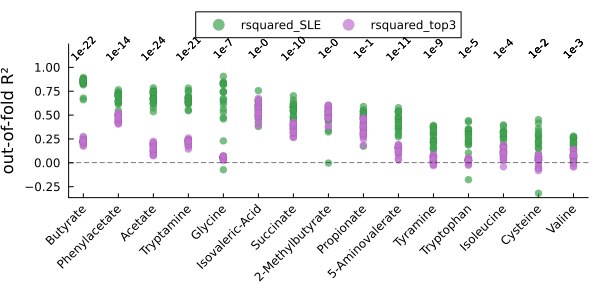

In [29]:
pltdf = filter(:metabolite_name => ∈(predictablemetabolites.metabolite_name), pltdf_full);
plot(
    ylabel="out-of-fold R²",
    bottommargin=12Plots.Measures.mm,
    xrotation=45,
    legend=:outertop,
    legendcolumns=2,
    size=(600, 300),
    xflip=true, 
)
@df pltdf dotplot!(
    string.(round.(:rsquared_SLE_mean, digits=6)), :value,
    group=:variable,
    mode=:none,
    side=[:left :right],
    alpha=.7,
    markerstrokewidth=0,
    xticks=((1:length(unique(:metabolite_name))).-.5, unique(:metabolite_name)),
    ylims=(-Inf, 1.2),
    widen=true,
    # label="Full lasso",
    c=[3 4],
)
hline!([0], c=:black, lw=.5, linestyle=:dash)
@df predictablemetabolites annotate!(
    string.(round.(:rsquared_SLE_mean, digits=6)), 
    ones(nrow(sigresults)) .+ 0.2,
    text.(
        # replace.(repeat.("*", :poweroftest), r"(.{5})"=>s"\1\n"),
        "1e-" .* string.(:poweroftest),
        7, :center, rotation=45
    ),
)

In [30]:
savefig(joinpath(pdir, "improvedmetabolites_sle-vs-top3_dotplot.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SLE_Lasso_model/improvedmetabolites_sle-vs-top3_dotplot.pdf"

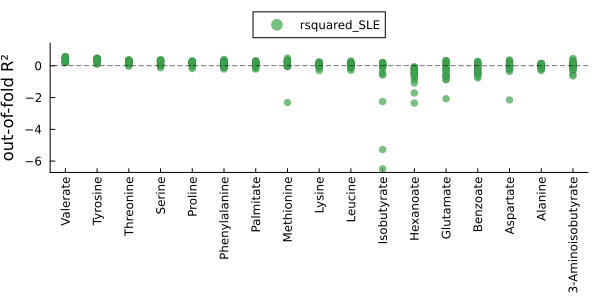

In [31]:
pltdf = filter(:metabolite_name => !∈(predictablemetabolites.metabolite_name), slelassopltdf);

plot(
    ylabel="out-of-fold R²",
    bottommargin=14Plots.Measures.mm,
    xrotation=90,
    legend=:outertop,
    # legendcolumns=2,
    size=(600, 300),
    xflip=true, 
)
@df pltdf dotplot!(
    string.(round.(:rsquared_SLE_mean, digits=6)), :value,
    group=:variable,
    mode=:none,
    side=[:left :right],
    alpha=.7,
    markerstrokewidth=0,
    xticks=((1:length(unique(:metabolite_name))).-.5, unique(:metabolite_name)),
    ylims=(-Inf, 1.2),
    widen=true,
    # label="Full lasso",
    c=[3 4],
)
hline!([0], c=:black, lw=.5, linestyle=:dash)
# @df predictablemetabolites annotate!(
#     string.(round.(:rsquared_SLE_mean, digits=6)), 
#     ones(nrow(sigresults)) .+ 0.1,
#     text.(
#         # replace.(repeat.("*", :poweroftest), r"(.{5})"=>s"\1\n"),
#         "1e-" .* string.(:poweroftest),
#         7, :center, rotation=90
#     ),
# )

In [32]:
savefig(joinpath(pdir, "notimprovedmetabolites_sle-vs-top3_dotplot.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SLE_Lasso_model/notimprovedmetabolites_sle-vs-top3_dotplot.pdf"

In [33]:
coefdf_avgbytreedist = groupby(coefdf, [:metabolite_name, :treedist]) |>
    df -> combine(df, 
        :coef => (x-> mean(x) - 1std(x)) => :coef_lowerbound,
        :coef => (x-> mean(x) + 1std(x)) => :coef_upperbound,
        :coef => (x-> mean(x)) => :coef_mean,
        :coef => (x-> mean(abs.(x))) => :coef_meanabs,
        :coef => (x-> median(x)) => :coef_median,
        :coef => (x-> quantile(x, 0.25)) => :coef_Q2,
        :coef => (x-> quantile(x, 0.75)) => :coef_Q3,
        nrow
    ) |>
    df -> DataFrames.transform(df,
        [:coef_lowerbound, :coef_upperbound] => ((lo, hi) -> lo .> 0 .|| hi .< 0) => :isnonzero,
    );

In [34]:
predictable_metabolite_idx = indexin(predictablemetabolites.metabolite_name, metabolite_names);

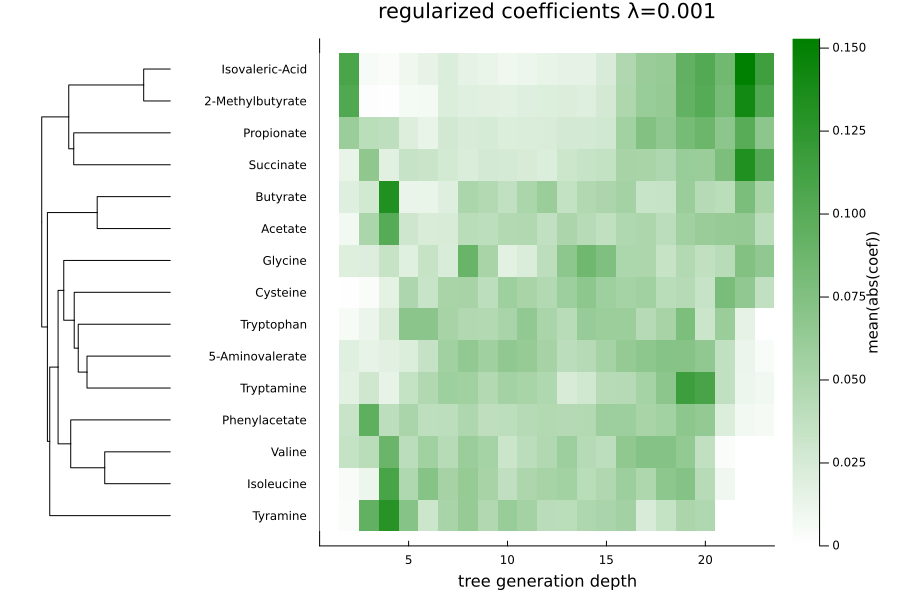

In [35]:
coef_mtxdf = unstack(coefdf_avgbytreedist, :metabolite_name, :treedist, :coef_meanabs) |>
    df -> df[indexin(metabolite_names, df.metabolite_name), :] |>
    df -> df[reverse(predictable_metabolite_idx), :] #|> 
coefmtx = Matrix(coef_mtxdf[:, 2:end])
coefmtx = coefmtx ./ sum(coefmtx, dims=2)
pltmtx = coefmtx

rowhc = hclust(pairwise(Euclidean(), coefmtx, dims=1), branchorder=:optimal);
roworder = rowhc.order #sortperm(vec(sum(abs.(coefmtx), dims=2)), rev=true)
# pltmtx = abs.(coefmtx)
# rownames = coef_mtxdf.metabolite_name
pltmtx = abs.(pltmtx[roworder, :])
rownames = coef_mtxdf.metabolite_name[roworder]

tplot = plot(
    # readnw(SPI.nwstr(rowhc, String.(coef_mtxdf.metabolite_name), labelinternalnodes=false)), 
    readnw(SPI.nwstr(rowhc, repeat([""], length(rowhc.order)), labelinternalnodes=false)), 
    fs=1
)

hplot = heatmap(pltmtx,
    title="regularized coefficients λ=$λ",
    yticks=(1:size(coefmtx, 1), rownames),
    # xticks=(2:2:10, (2:2:10) .* 10),
    # clims = extrema(coefmtx) |> x->abs.(x) |> maximum |> x->(-x, x),
    colorbartitle="mean(abs(coef))",
    xlabel="tree generation depth",
    c=[:white, :green],
    size=(900, 600),
    margin=3Plots.Measures.mm,
)

layout = @layout [a{.2w} b]
plot(tplot, hplot, link=:y, layout=layout)

In [36]:
savefig(joinpath(pdir, "Coeff_heatmap_clusteredimprovedmetabolites.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SLE_Lasso_model/Coeff_heatmap_clusteredimprovedmetabolites.pdf"

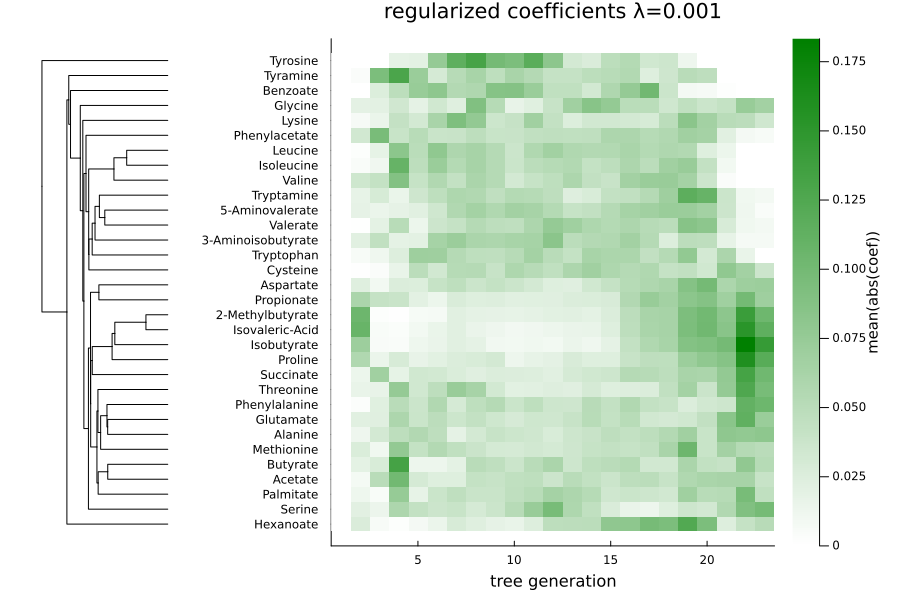

In [37]:
coef_mtxdf = unstack(coefdf_avgbytreedist, :metabolite_name, :treedist, :coef_meanabs) |>
    df -> df[indexin(metabolite_names, df.metabolite_name), :] # |>
    # df -> df[keepmetabolites_mask, :] #|> 
coefmtx = Matrix(coef_mtxdf[:, 2:end])
coefmtx = coefmtx ./ sum(coefmtx, dims=2)
pltmtx = coefmtx

rowhc = hclust(pairwise(Euclidean(), coefmtx, dims=1), branchorder=:optimal);
roworder = rowhc.order #sortperm(vec(sum(abs.(coefmtx), dims=2)), rev=true)
# pltmtx = abs.(coefmtx)
# rownames = coef_mtxdf.metabolite_name
pltmtx = abs.(pltmtx[roworder, :])
rownames = coef_mtxdf.metabolite_name[roworder]

tplot = plot(
    # readnw(SPI.nwstr(rowhc, String.(coef_mtxdf.metabolite_name), labelinternalnodes=false)), 
    readnw(SPI.nwstr(rowhc, repeat([""], length(rowhc.order)), labelinternalnodes=false)), 
    fs=1
)

hplot = heatmap(pltmtx,
    title="regularized coefficients λ=$λ",
    yticks=(1:size(coefmtx, 1), rownames),
    # xticks=(2:2:10, (2:2:10) .* 10),
    # clims = extrema(coefmtx) |> x->abs.(x) |> maximum |> x->(-x, x),
    colorbartitle="mean(abs(coef))",
    xlabel="tree generation",
    c=[:white, :green],
    size=(900, 600),
    margin=3Plots.Measures.mm,
)

layout = @layout [a{.2w} b]
plot(tplot, hplot, link=:y, layout=layout)

In [38]:
savefig(joinpath(pdir, "Coeff_heatmap_clusteredmetabolites_greaterthan10pctmeasurements.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SLE_Lasso_model/Coeff_heatmap_clusteredmetabolites_greaterthan10pctmeasurements.pdf"

In [39]:
metabolite_name = "Acetate"
# metabolite_name = "Phenylacetate"

"Acetate"

In [40]:
for r in 1:5
    predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked) |>
        df -> subset(df, :resample => x-> x.==r) |>
        df -> sort(df, :row_id)

    lims = extrema(vcat(predsdf.preds, predsdf.truth))
    lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
    plot(identity, -20, 20, c=:black, lw=.5, label="")
    p1 = @df predsdf scatter!(:preds, :truth,
        group=trnYdf.species[:row_id],
        lims=lims,
        title="SPI LASSO (λ=$λ, K=1, resmp=$r)",
        ylabel=metabolite_name * " (truth)",
        xlabel=metabolite_name * " (prediction)",
        grid=false,
        markerstrokewidth=0,
        ratio=1,
        c=speciescolors_ordered,
        size=(900,600),
        legend=:outerright,
        xrotation=90,
        alpha=.5,
        margin=5Plots.Measures.mm,

    )
    savefig(joinpath(pdir, "$(metabolite_name)_resample$(r)_scatter_preds_vs_truth.pdf"))
end

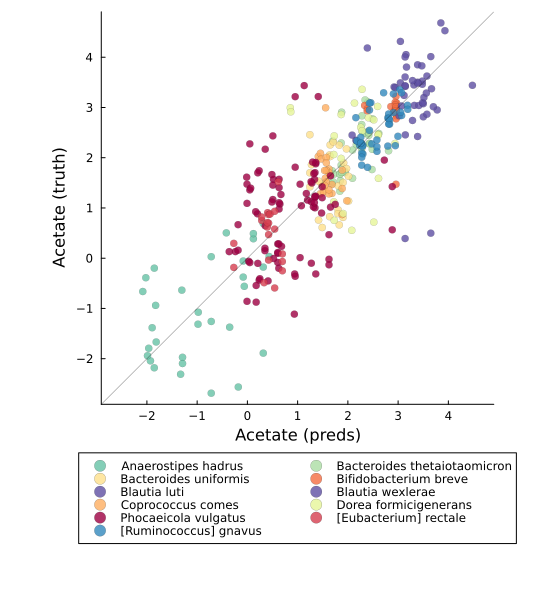

In [41]:
r = 5
predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked) |>
    df -> filter(:resample => ==(r), df)
@df predsdf scatter(
    :preds, :truth,
    group=trnYdf.species[:row_id],
    c=speciescolors_ordered,
    lims=extrema(vcat(:preds, :truth)),
    widen=true,
    ratio=1,
    size=(550,600),
    legend=:outerbottom,
    legend_column=2,
    markerstrokewidth=.1,
    alpha=.8,
    xlabel="$metabolite_name (preds)",
    ylabel="$metabolite_name (truth)",
)
plot!(identity, -20, 20, c=:black, alpha=.5, lw=0.5)

In [42]:
for r in 1:5
    predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked_top3) |>
        df -> subset(df, :resample => x-> x.==r) |>
        df -> sort(df, :row_id)

    lims = extrema(vcat(predsdf.preds, predsdf.truth))
    lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
    plot(identity, -20, 20, c=:black, lw=.5, label="")
    p1 = @df predsdf scatter!(:preds, :truth,
        group=trnYdf.species[:row_id],
        lims=lims,
        title="SPI LASSO (λ=$λ, K=1, resmp=$r)",
        ylabel=metabolite_name * " (truth)",
        xlabel=metabolite_name * " (prediction)",
        grid=false,
        markerstrokewidth=0,
        ratio=1,
        c=speciescolors_ordered,
        size=(900,600),
        legend=:outerright,
        xrotation=90,
        alpha=.5,
        margin=5Plots.Measures.mm,

    )
    savefig(joinpath(pdir, "$(metabolite_name)_resample$(r)_scatter_preds_vs_truth_top3.pdf"))
end

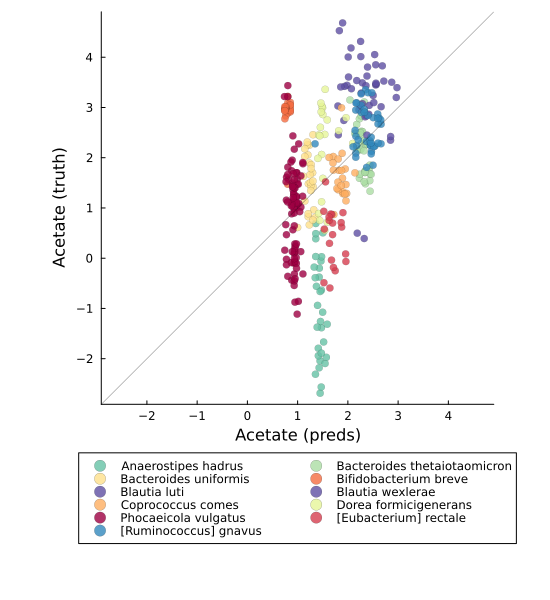

In [43]:
r = 5
predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked_top3) |>
    df -> filter(:resample => ==(r), df)
@df predsdf scatter(
    :preds, :truth,
    group=trnYdf.species[:row_id],
    c=speciescolors_ordered,
    lims=extrema(vcat(:preds, :truth)),
    widen=true,
    ratio=1,
    size=(550,600),
    legend=:outerbottom,
    legend_column=2,
    markerstrokewidth=.1,
    alpha=.8,
    xlabel="$metabolite_name (preds)",
    ylabel="$metabolite_name (truth)",
)
plot!(identity, -20, 20, c=:black, alpha=.5, lw=0.5)

In [44]:
for r in 1:5
    predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked_top10) |>
        df -> subset(df, :resample => x-> x.==r) |>
        df -> sort(df, :row_id)

    lims = extrema(vcat(predsdf.preds, predsdf.truth))
    lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
    plot(identity, -20, 20, c=:black, lw=.5, label="")
    p1 = @df predsdf scatter!(:preds, :truth,
        group=trnYdf.species[:row_id],
        lims=lims,
        title="SPI LASSO (λ=$λ, K=1, resmp=$r)",
        ylabel=metabolite_name * " (truth)",
        xlabel=metabolite_name * " (prediction)",
        grid=false,
        markerstrokewidth=0,
        ratio=1,
        c=speciescolors_ordered,
        size=(900,600),
        legend=:outerright,
        xrotation=90,
        alpha=.5,
        margin=5Plots.Measures.mm,

    )
    savefig(joinpath(pdir, "$(metabolite_name)_resample$(r)_scatter_preds_vs_truth_top10.pdf"))
end

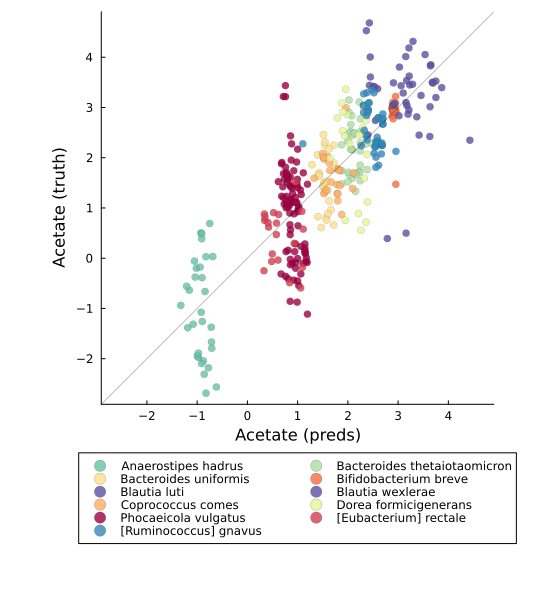

In [45]:
r = 5
predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked_top10) |>
    df -> filter(:resample => ==(r), df)
@df predsdf scatter(
    :preds, :truth,
    group=trnYdf.species[:row_id],
    c=speciescolors_ordered,
    lims=extrema(vcat(:preds, :truth)),
    widen=true,
    ratio=1,
    size=(550,600),
    legend=:outerbottom,
    legend_column=2,
    markerstrokewidth=.1,
    alpha=.8,
    xlabel="$metabolite_name (preds)",
    ylabel="$metabolite_name (truth)",
)
plot!(identity, -20, 20, c=:black, alpha=.5, lw=0.5)

## Plot Tree with metabolites

In [54]:
# speciescolors = shuffle(permutedims(palette(:Spectral_10, 10).speciescolors.colors))
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
speciesvector = bbobs_trn.species[subsettree_hc.order]
length(unique(speciesvector))

breaks = findall(speciesvector[begin:(end-1)] .!= speciesvector[2:end])[Not([10, 11, 12, 13, 14,15])]
edges = [(s, e) for (s,e) in zip(vcat([0],breaks), vcat(breaks, [length(speciesvector)]))];
rects = [rectangle(2,(e-s),0,s+.5) for (s,e) in zip(vcat([0],breaks), vcat(breaks, [length(speciesvector)]))];

plot(subsettree_hc, 
    # size=(600, 900),
    lw=.5,
    yflip=true, 
    xmirror=true,
    xticks=:none,
    permute=(:y, :x),
    grid=false,
    tickdirection=:none,
    rightmargin=1Plots.Measures.mm, 
    label="",
    framestyle=:grid,
)
plot!(permutedims(rects[Not(8, 12)]), fill=0.35, lw=0, c=speciescolors, label="")
plot!(rects[8], fill=0.35, lw=0, c=speciescolors[4], label="")
plot!(rects[12], fill=0.35, lw=0, c=speciescolors[9], label="")
specieslabels= [
    "Bacteroides uniformis",
    "Phocaeicola vulgatus",
    "Bacteroides thetaiotaomicron",
    "[Ruminococcus] gnavus",
    "Bifidobacterium breve",
    "[Eubacterium] rectale",
    "Dorea formicigenerans",
    "Coprococcus comes",
    "Blautia luti & Blautia wexlerae",
    "Anaerostipes hadrus",
]
fancy_treeplot = plot!(zeros(1, 10), 
    legend=:left,
    labels=permutedims(reverse(specieslabels)), 
    c=reverse(speciescolors),
    legendfontsize=5,
);


In [61]:
treeorder = indexin(getleafnames(subsettree), bbobs_trn.ID);
clims = metab_trnY |> extrema |> x->abs.(x) |> maximum |> x->(-x, x)
hplot = heatmap(metab_trnY[treeorder, :],
    c=:bwr, clims=clims,
    xticks=(1:size(metab_trnY,2), metabolite_names),
    xrotation=90, xtickfontsize=7,
    yticks=:none,
);

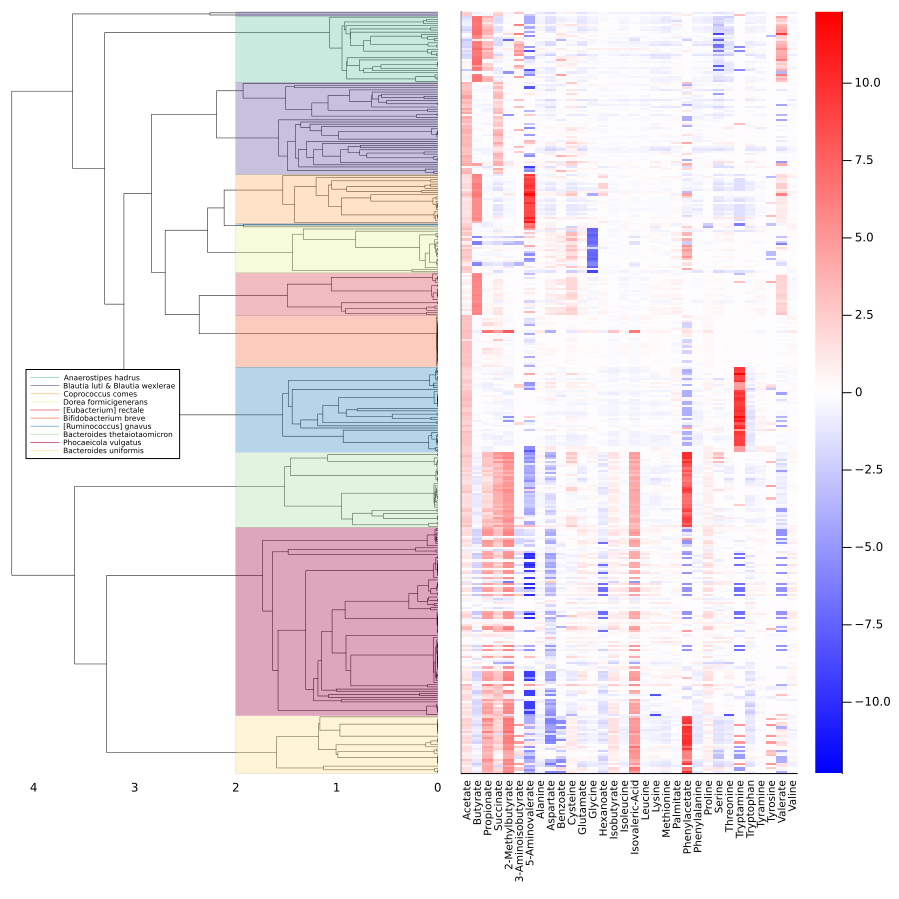

In [62]:

plot(fancy_treeplot, hplot, size=(900,900))

## Plot SLE Preds against alternative

56960×6 DataFrame
   Row │ row_id  metabolite_name  fold   resample  truth       preds      
       │ Int64   String           Int64  Int64     Float64     Float64    
───────┼──────────────────────────────────────────────────────────────────
     1 │    342  Acetate              1         1   2.35396     2.61133
     2 │     90  Acetate              1         1   0.198325    0.694874
     3 │    121  Acetate              1         1   0.906867    0.535348
     4 │    223  Acetate              1         1   2.45019     3.10572
     5 │    163  Acetate              1         1   0.962586    1.80566
     6 │    285  Acetate              1         1   3.0863      2.61133
     7 │     82  Acetate              1         1  -0.0611344   0.0224312
     8 │    133  Acetate              1         1   2.85979     1.87079
   ⋮   │   ⋮            ⋮           ⋮       ⋮          ⋮           ⋮
 56954 │    170  Valine               4         5   1.1932      0.133518
 56955 │    264  Valine               4         5   0.0885085   0.0162928
 56956 │     24  Valine               4         5   0.384005    0.382765
 56957 │    106  Valine               4         5   1.23039     0.0192463
 56958 │    148  Valine               4         5   0.488847    0.0389307
 56959 │    345  Valine               4         5   0.0122909  -0.125681
 56960 │    294  Valine               4         5  -0.182895   -0.0852253
                                                        56945 rows omitted

In [77]:
ps = []
for mname in sort(predictablemetabolites, :rsquared_SLE_mean, rev=true).metabolite_name
    pltdf = filter(:metabolite_name => ==(mname), oof_preds_df_stacked) |>
        df -> filter(:resample => ==(5), df)
    p = plot(identity, -20, 20, c=:black, alpha=.5, lw=0.5)
    p = @df pltdf scatter!(:preds, :truth,
        group=trnYdf.species[:row_id],
        c=speciescolors_ordered,
        lims=extrema(vcat(:preds, :truth)),
        widen=true,
        ratio=1, legend=:none,
        markerstrokewidth=0.0,
        markersize=2,
        alpha=.5,
        xrotation=45,
        title=mname,
        # xlabel="$mname (SLE)",
        # ylabel="$mname (full)",
        tickdirection=:none,
        framestyle=:box,
        framelinewidth=0.5,
    )
    push!(ps, p)
end

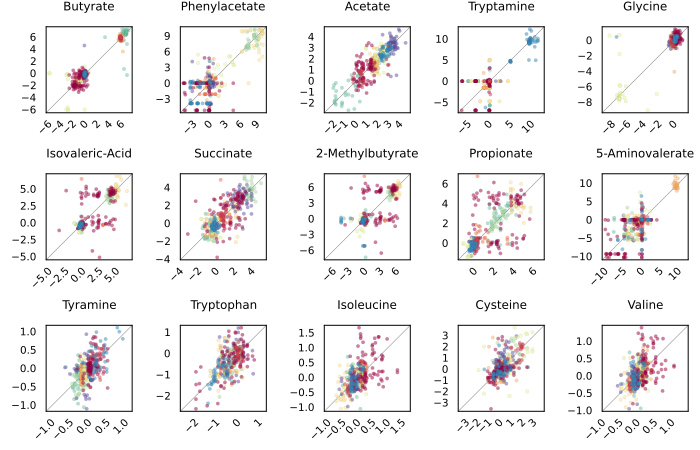

In [78]:
plot(ps..., layout=grid(3,5), titlefontsize=8, labelfontsize=6, tickfontsize=7, size=(700,450))

In [79]:
savefig(joinpath(pdir, "improvedmetabolites_SLEpreds-vs-truth.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SLE_Lasso_model/improvedmetabolites_SLEpreds-vs-truth.pdf"

## Plot Hadrus tree with metabolite truth & predictions

In [80]:
treeorder = indexin(getleafnames(subsettree), bbobs_trn.ID);

In [85]:
hadrusnames = bbobs_trn.ID[findall(contains.(bbobs_trn.species, "hadrus"))]
hadrus_treeidxs = indexin(hadrusnames, getleafnames(subsettree));
hadrustree = readnw(NewickTree.nwstr(NewickTree.extract(subsettree, hadrusnames)))
hadrusnames = getleafnames(hadrustree)
hadrus_treeidxs = indexin(hadrusnames, getleafnames(subsettree));

In [90]:
pltdf = filter(:metabolite_name => ==("Acetate"), oof_preds_df_stacked) |>
    df -> filter(:resample => ==(5), df) |>
    df -> sort(df, :row_id);
hadruspltdf = pltdf[treeorder, :][hadrus_treeidxs, :];

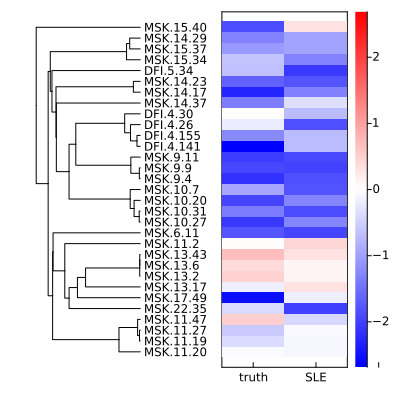

In [91]:
pltmtx = Matrix(hadruspltdf[:, [:truth, :preds]])
clims = getlims(pltmtx)
hp = heatmap(pltmtx,
    c=:bwr, clims=clims,
    xticks=(1:3, ["truth", "SLE"]),
    yticks=false,
    framestyle=:box
)
tp = plot(hadrustree, fs=8, rightmargin=15Plots.Measures.mm)
layout = @layout [a{.4w} b]
plot(tp, hp, layout=layout, link=:y, size=(400,400))

In [92]:
savefig(joinpath(pdir, "Ahadrus_Acetate_treeandpredictions_truth-SLE.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SLE_Lasso_model/Ahadrus_Acetate_treeandpredictions_truth-SLE.pdf"

## Plot OGGS that separate A. hadrus acetate clades

In [27]:
hadrusIDs = bbobs_trn.ID[contains.(bbobs_trn.species, "hadrus")]
hadrusancestor = NewickTree.extract(subsettree, hadrusIDs)

((((MSK.11.20:0.2185118,((MSK.11.19:0.007115789,MSK.11.27:0.007115789):0.01952213,MSK.11.47:0.02663792):0.1918739):0.6826251,(((MSK.22.35:0.7317976,(MSK.17.49:0.6459351,(MSK.13.17:0.5621654,(MSK.13.2:0.005003621,(MSK.13.6:0.004403209,MSK.13.43:0.004403209):0.0006004121):0.5571618):0.08376975):0.08586242):0.04431587,MSK.11.2:0.7761134):0.120572,MSK.6.11:0.8966854):0.004451496):0.04604542,((((((((MSK.10.27:0.01044862,MSK.10.31:0.01044862):0.05242078,MSK.10.20:0.0628694):0.03998712,MSK.10.7:0.1028565):0.6292068,(((MSK.9.4:0.008945339,MSK.9.9:0.008945339):0.0874901,MSK.9.11:0.09643544):0.566493,(((DFI.4.141:0.03331342,DFI.4.155:0.03331342):0.06626768,DFI.4.26:0.0995811):0.06017711,DFI.4.30:0.1597582):0.5031702):0.06913491):0.130885,MSK.14.37:0.8629483):0.003442671,(MSK.14.17:0.07033848,MSK.14.23:0.07033848):0.7960525):0.04170974,DFI.5.34:0.9081008):0.01721933,(MSK.15.34:0.1403227,(MSK.15.37:0.1083422,MSK.14.29:0.1083422):0.03198043):0.7849974):0.02186222):0.1228962,MSK.15.40:1.070079);

In [28]:
node = children(hadrusancestor)[1]

(((MSK.11.20:0.2185118,((MSK.11.19:0.007115789,MSK.11.27:0.007115789):0.01952213,MSK.11.47:0.02663792):0.1918739):0.6826251,(((MSK.22.35:0.7317976,(MSK.17.49:0.6459351,(MSK.13.17:0.5621654,(MSK.13.2:0.005003621,(MSK.13.6:0.004403209,MSK.13.43:0.004403209):0.0006004121):0.5571618):0.08376975):0.08586242):0.04431587,MSK.11.2:0.7761134):0.120572,MSK.6.11:0.8966854):0.004451496):0.04604542,((((((((MSK.10.27:0.01044862,MSK.10.31:0.01044862):0.05242078,MSK.10.20:0.0628694):0.03998712,MSK.10.7:0.1028565):0.6292068,(((MSK.9.4:0.008945339,MSK.9.9:0.008945339):0.0874901,MSK.9.11:0.09643544):0.566493,(((DFI.4.141:0.03331342,DFI.4.155:0.03331342):0.06626768,DFI.4.26:0.0995811):0.06017711,DFI.4.30:0.1597582):0.5031702):0.06913491):0.130885,MSK.14.37:0.8629483):0.003442671,(MSK.14.17:0.07033848,MSK.14.23:0.07033848):0.7960525):0.04170974,DFI.5.34:0.9081008):0.01721933,(MSK.15.34:0.1403227,(MSK.15.37:0.1083422,MSK.14.29:0.1083422):0.03198043):0.7849974):0.02186222):0.1228962;

In [29]:
using Random: seed!

In [30]:
function hierarchical_q_test(mtx, grp1_idx, grp2_idx; nperms=100, seed=424242)
    # make null
    seed!(seed)
    null_qs = map(1:nperms) do i
        perm_idx = shuffle(axes(mtx, 1))
        qs = mapslices(mtx, dims=1) do column
            q = pvalue(MannWhitneyUTest(column[perm_idx][grp1_idx], column[perm_idx][grp2_idx]))
        end
        minimum(qs)
    end
    # compare reference pval to null pvals
    qvals = mapslices(mtx, dims=1) do column
        pval = pvalue(MannWhitneyUTest(column[grp1_idx], column[grp2_idx]))
        mean(null_qs .< pval)
    end |> vec
end

function log2FC(a, b) 
    mean(log2.(a .+ 1)) - mean(log2.(b .+ 1))
end

log2FC (generic function with 1 method)

In [31]:
 # 1 vs. sibling
 grp1_idx = indexin(getleafnames(children(node)[1]), bbobs_trn.ID)
 grp2_idx = indexin(getleafnames(children(node)[2]), bbobs_trn.ID)
 qs = hierarchical_q_test(bbmtx_trn, grp1_idx, grp2_idx, nperms=100)
 qs_bh = adjust(qs, BenjaminiHochberg()) 
 oggsigmask = qs_bh .< 0.05;

In [32]:
bbogg_names = biobank["oggs"].var_names[ogg_mask]
hadrussplit_sigoggnames = bbogg_names[oggsigmask];

In [33]:
sum(oggsigmask)

26

In [34]:
log2fc_measures = mapslices(bbmtx_trn, dims=1) do col
    log2FC(col[grp1_idx], col[grp2_idx])
end |> vec;

In [35]:
upvarmeta = CSV.read(datadir("exp_raw","UP7047","UPcolmeta.csv"), DataFrame);

In [36]:
hadrussplit_oggannotations = upvarmeta[filter(!isnothing, indexin(hadrussplit_sigoggnames, upvarmeta.og)), :];

In [116]:
CSV.write(joinpath(rdir, "Ahadrus_largenode_sigoggs_annotations.csv"), hadrussplit_oggannotations)

"/Users/ben/projects/Doran_etal_2022/_research/metabolite_SLE_Lasso_model/Ahadrus_largenode_sigoggs_annotations.csv"

## Plot Ahadrus sig OGGs

In [10]:
pltoggsdf = CSV.read(joinpath(rdir, "Ahadrus_largenode_sigoggs_annotations.csv"), DataFrame)

23×6 DataFrame
 Row │ og       level  nm     description                        COG_categorie ⋯
     │ String7  Int64  Int64  String                             String3       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2Z80J        2     55  Psort location Cytoplasmic, scor…  S             ⋯
   2 │ 32SVU        2     77  Psort location CytoplasmicMembra…  S
   3 │ 32Z5Y        2     57  Domain of unknown function (DUF4…  S
   4 │ COG0191      2   5778  fructose-bisphosphate aldolase a…  G
   5 │ COG0246      2   3298  mannitol metabolic process         G             ⋯
   6 │ COG0328      2   5074  RNA-DNA hybrid ribonuclease acti…  L
   7 │ COG0609      2  11268  iron ion homeostasis               P
   8 │ COG0614      2  13606  abc-type fe3 -hydroxamate transp…  P
  ⋮  │    ⋮       ⋮      ⋮                    ⋮                        ⋮       ⋱
  17 │ COG3958      2   2176  transketolase activity             G             ⋯
  18 │ COG3959      2   2166  transketolase activity             G
  19 │ COG4227      2   1991  nucleotidyltransferase activity    L
  20 │ COG4509      2    858  Sortase family                     S
  21 │ COG4886      2   8357  regulation of response to stimul…  S             ⋯
  22 │ COG4988      2   2325  cysteine transport                 V
  23 │ COG5386      2    347  Cell surface protein               M
                                                    2 columns and 8 rows omitted

In [24]:
treeorder = indexin(getleafnames(subsettree), bbobs_trn.ID);

In [25]:
hadrusnames = bbobs_trn.ID[findall(contains.(bbobs_trn.species, "hadrus"))]
hadrus_treeidxs = indexin(hadrusnames, getleafnames(subsettree));
hadrustree = readnw(NewickTree.nwstr(NewickTree.extract(subsettree, hadrusnames)))
hadrusnames = getleafnames(hadrustree)
hadrus_treeidxs = indexin(hadrusnames, getleafnames(subsettree));

In [37]:
oggorder = sortperm(log2fc_measures[indexin(pltoggsdf.og, bbogg_names)]);

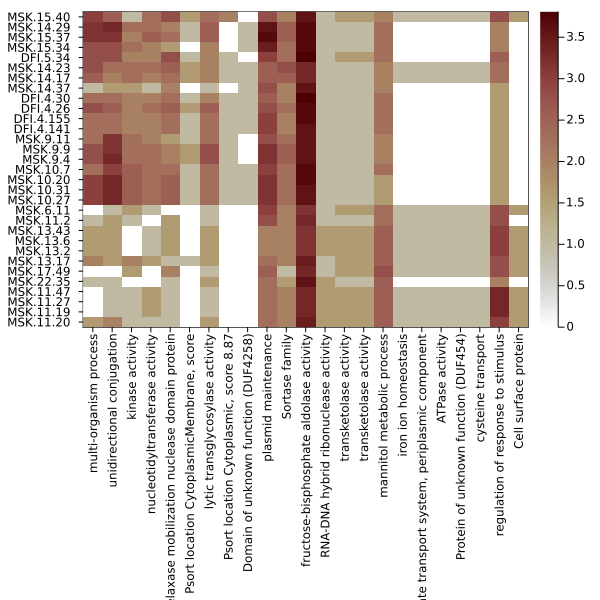

In [38]:
# plotlyjs()
pltmtx = bbmtx_trn[treeorder, :][hadrus_treeidxs,indexin(pltoggsdf.og, bbogg_names)][:, oggorder]
pltmtx = log2.(pltmtx .+ 1)
heatmap(pltmtx, 
    c=:bilbao,
    yticks=(1:size(pltmtx, 1), hadrusnames),
    xticks=(1:size(pltmtx,2), pltoggsdf.description[oggorder]),
    xrotation=90,
    size=(600,600),
    tickdirection=:out,
    framestyle=:box,
    bottommargin=-40Plots.Measures.mm,
)

In [39]:
savefig(joinpath(pdir, "Ahadrus_sigoggs_heatmap_annotatedbyfunction_grbackend.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SLE_Lasso_model/Ahadrus_sigoggs_heatmap_annotatedbyfunction_grbackend.pdf"

In [123]:
gr()

Plots.GRBackend()

## Number of params for SLE models

In [124]:
metabolite_num_params = groupby(coefdf, [:metabolite_name, :fold]) |>
    df -> combine(df, :coef => (x->sum(x.>0)) => :num_params) |>
    df -> groupby(df, :metabolite_name) |>
    df -> combine(df, :num_params => mean) |>
    df -> sort(df, :num_params_mean)
    # df -> filter(:metabolite_name => ==("Acetate"), df)

32×2 DataFrame
 Row │ metabolite_name     num_params_mean 
     │ String              Float64         
─────┼─────────────────────────────────────
   1 │ Tyrosine                      25.05
   2 │ 3-Aminoisobutyrate            37.15
   3 │ Leucine                       37.85
   4 │ Valine                        39.75
   5 │ Isobutyrate                   40.75
   6 │ Tyramine                      41.45
   7 │ Isoleucine                    41.95
   8 │ Tryptamine                    42.8
  ⋮  │         ⋮                  ⋮
  26 │ Acetate                       63.9
  27 │ Cysteine                      64.7
  28 │ Propionate                    69.35
  29 │ Phenylacetate                 69.65
  30 │ Succinate                     72.15
  31 │ Aspartate                     75.9
  32 │ 5-Aminovalerate               83.9
                            17 rows omitted

In [125]:
CSV.write(joinpath(rdir, "metabolite_avg_num_params_SLE.csv"),metabolite_num_params)

"/Users/ben/projects/Doran_etal_2022/_research/metabolite_SLE_Lasso_model/metabolite_avg_num_params_SLE.csv"

In [126]:
coefdf

170240×7 DataFrame
    Row │ metabolite_name  fold   treedepth  class      node_id    coef        ⋯
        │ String           Int64  SubStrin…  SubStrin…  String     Float64     ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ Acetate              1  node       1          node__1    -0.0        ⋯
      2 │ Acetate              1  node       2          node__2    -0.0212018
      3 │ Acetate              1  node       3          node__3     0.00990903
      4 │ Acetate              1  node       4          node__4    -0.866683
      5 │ Acetate              1  node       5          node__5     0.0        ⋯
      6 │ Acetate              1  node       6          node__6     0.166247
      7 │ Acetate              1  node       7          node__7     0.0
      8 │ Acetate              1  node       8          node__8    -0.102224
   ⋮    │        ⋮           ⋮        ⋮          ⋮          ⋮           ⋮      ⋱
 170234 │ Valine              20  node       260        node__260   0.342653   ⋯
 170235 │ Valine              20  node       261        node__261  -0.0
 170236 │ Valine              20  node       262        node__262  -0.0
 170237 │ Valine              20  node       263        node__263   0.0
 170238 │ Valine              20  node       264        node__264  -0.0        ⋯
 170239 │ Valine              20  node       265        node__265  -0.0
 170240 │ Valine              20  node       266        node__266  -0.0
                                                1 column and 170225 rows omitted

In [44]:
usvcsb = svd(bbmtx);

In [49]:
sum(explainedvariance(usvcsb.S)[1:3])

0.8633655184987827

In [56]:
sum(explainedvariance(usvcsb.S)[end-2:end])

1.1120522356456682e-32

In [58]:
explainedvariance(usvcsb.S)

669-element Vector{Float64}:
 0.6857432635553667
 0.1614449363528334
 0.0161773185905826
 0.014043872302378033
 0.012059400001284451
 0.00847947264387949
 0.007602421579353761
 0.007002405381427087
 0.006578864258462991
 0.006102826214803219
 ⋮
 5.4793124944891105e-33
 5.4793124944891105e-33
 5.4793124944891105e-33
 5.4793124944891105e-33
 5.4793124944891105e-33
 5.4793124944891105e-33
 5.4793124944891105e-33
 5.4793124944891105e-33
 1.618973674784616e-34